Last updated on Jun 15, 2024

# Skipping vertical interpolation in QGField

In [1]:
import datetime as dt
from math import pi
import numpy as np
from numpy import dtype
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
from falwa.oopinterface import QGFieldNH18
import falwa.utilities as utilities

## Load ERA-Interim reanalysis data retrieved from ECMWF server
The sample script in this directory `download_example.py` include the code to retrieve zonal wind field U, meridional
wind field V and temperature field T at various pressure levels. Given that you have an account on ECMWF server and
have the `ecmwfapi` package installed, you can run the scripts to download data from there:
```
python download_example.py
```

In [2]:
u_file = xr.open_dataset('2005-01-23_to_2005-01-30_u.nc')
v_file = xr.open_dataset('2005-01-23_to_2005-01-30_v.nc')
t_file = xr.open_dataset('2005-01-23_to_2005-01-30_t.nc')
ntimes = u_file.time.size
time_array = u_file.time

In [3]:
u_file

<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 121, level: 37, time: 32)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2005-01-23 ... 2005-01-30T18:00:00
Data variables:
    u          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2018-07-17 16:50:39 GMT by grib_to_netcdf-2.8.0: grib_to_ne...

## Load the dimension arrays
In this version, the `QGField` object takes only:
- latitude array in degree ascending order, and 
- pressure level in hPa in decending order (from ground to aloft).

In [4]:
xlon = u_file.longitude.values

# latitude has to be in ascending order
ylat = u_file.latitude.values[::-1]

# pressure level has to be in descending order (ascending height)
plev = u_file.level.values[::-1]

nlon = xlon.size
nlat = ylat.size
nlev = plev.size

In [5]:
clat = np.cos(np.deg2rad(ylat))     # cosine latitude
p0 = 1000.                          # surface pressure [hPa]
kmax = 49                           # number of grid points for vertical extrapolation (dimension of height)
dz = 1000.                          # differential height element
height = np.arange(0,kmax)*dz       # pseudoheight [m]
dphi = np.diff(ylat)[0]*pi/180.     # differential latitudinal element
dlambda = np.diff(xlon)[0]*pi/180.  # differential latitudinal element
hh = 7000.                          # scale height
cp = 1004.                          # heat capacity of dry air
rr = 287.                           # gas constant
omega = 7.29e-5                     # rotation rate of the earth
aa = 6.378e+6                       # earth radius
prefactor = np.array([np.exp(-z/hh) for z in height[1:]]).sum() # integrated sum of density from the level
                                                                #just above the ground (z=1km) to aloft
npart = nlat                        # number of partitions to construct the equivalent latitude grids
maxits = 100000                     # maximum number of iteration in the SOR solver to solve for reference state
tol = 1.e-5                         # tolerance that define convergence of solution
rjac = 0.95                         # spectral radius of the Jacobi iteration in the SOR solver.              
jd = nlat//2+1                      # (one plus) index of latitude grid point with value 0 deg
                                    # This is to be input to fortran code. The index convention is different.
zlev = -hh * np.log(plev/p0)

In [6]:
zlev

array([   -0.        ,   177.22465589,   359.05306071,   545.73079029,
         737.5236096 ,   934.71974837,  1137.63250648,  1346.60324853,
        1562.0048592 ,  1784.2457474 ,  2013.77450716,  2496.72460757,
        3015.48041265,  3575.77936636,  4184.85900529,  4852.03026392,
        5589.55387352,  6414.03512312,  7348.75487149,  8427.80963028,
        9704.06052784, 10441.58413744, 11266.06538704, 12200.78513541,
       13279.8398942 , 14556.09079176, 16118.09565096, 18614.82025853,
       20970.12591488, 24545.90528124, 27384.161038  , 32236.19130192,
       34732.91590949, 37088.22156584, 40664.0009322 , 43502.25668896,
       48354.28695287])

In [7]:
height

array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
        8000.,  9000., 10000., 11000., 12000., 13000., 14000., 15000.,
       16000., 17000., 18000., 19000., 20000., 21000., 22000., 23000.,
       24000., 25000., 26000., 27000., 28000., 29000., 30000., 31000.,
       32000., 33000., 34000., 35000., 36000., 37000., 38000., 39000.,
       40000., 41000., 42000., 43000., 44000., 45000., 46000., 47000.,
       48000.])

## Set the level of pressure and the timestamp to display below

In [8]:
tstamp = [dt.datetime(2005,1,23,0,0) + dt.timedelta(seconds=6*3600) * tt for tt in range(ntimes)]
plev_selected = 10 # selected pressure level to display
tstep_selected = 0

## Interpolate onto regular pseudoheight grid before passing the field into QGField

In [9]:
from scipy.interpolate import interp1d

interp_to_regular_zgrid = lambda field_to_interp: interp1d(
    zlev, field_to_interp, axis=0, kind='linear', fill_value='extrapolate')(height)

new_plev = p0 * np.exp(-height/hh)

## Run QGField calculation without doing vertical interpolation

This can be done by setting `data_on_evenly_spaced_pseudoheight_grid=True`

In [10]:
zlev.shape

(37,)

In [11]:
u_file.u.isel(time=1).values[::-1, ::-1, :].shape

(37, 121, 240)

In [12]:
height

array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
        8000.,  9000., 10000., 11000., 12000., 13000., 14000., 15000.,
       16000., 17000., 18000., 19000., 20000., 21000., 22000., 23000.,
       24000., 25000., 26000., 27000., 28000., 29000., 30000., 31000.,
       32000., 33000., 34000., 35000., 36000., 37000., 38000., 39000.,
       40000., 41000., 42000., 43000., 44000., 45000., 46000., 47000.,
       48000.])

In [13]:
u_file.u.isel(time=0).values[-1, :, :].mean(axis=-1)

array([-4.9845377e-05,  3.3035126e+00,  5.7370496e+00,  8.6738882e+00,
        9.4568739e+00,  5.7631783e+00,  1.7548324e+00, -6.7173576e-01,
       -1.4388273e+00, -1.4515249e+00, -1.1203611e+00,  9.3382543e-01,
        1.6276387e+00,  1.0899996e+00,  1.2648599e+00,  9.5690328e-01,
        7.9047906e-01,  1.0288429e+00,  1.4075443e+00,  1.0858532e+00,
        2.2550067e-01,  1.2233507e-01,  9.9919602e-02, -2.4882247e-01,
       -7.7252591e-01, -1.2370020e+00, -1.0782945e+00, -4.5552814e-01,
       -2.1041241e-01, -2.9563013e-02,  8.9200366e-01,  1.6083473e+00,
        1.6804165e+00,  1.8145349e+00,  2.4297714e+00,  3.1639094e+00,
        3.4734786e+00,  3.8251002e+00,  3.9292302e+00,  3.7773752e+00,
        3.9184902e+00,  3.4779556e+00,  2.6353543e+00,  1.8616117e+00,
        8.7264031e-01, -1.1782823e-01, -1.1571876e+00, -1.9943041e+00,
       -2.6764989e+00, -3.3673608e+00, -3.9111333e+00, -4.6220345e+00,
       -5.1017709e+00, -5.0975819e+00, -4.9439850e+00, -4.5982666e+00,
      


            self.plev = [1000.          866.87789975  751.47729308  651.43905753  564.71812201
  489.54165956  424.37284568  367.87944117  318.90655732  276.45304663
  239.65103644  207.74818714  180.09231215  156.11804532  135.33528324
  117.31916609  101.7013923    88.16268936   76.42628699   66.25225915
   57.43261927   49.78706837   43.15930926   37.41385137   32.43324089
   28.11565975   24.37284407   21.12827988   18.31563889   15.87742257
   13.76378673   11.93152254   10.3431732     8.96626826    7.7726598
    6.737947      5.84097734    5.06341417    4.38936184    3.80504078
    3.29850576    2.85940174    2.47875218    2.14877548    1.86272598
    1.61475598    1.39979627    1.21345245    1.05191511]
            self.kmax = 49
            self._plev_to_height = [   -0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000.
 10000. 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000.
 20000. 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000.
 300

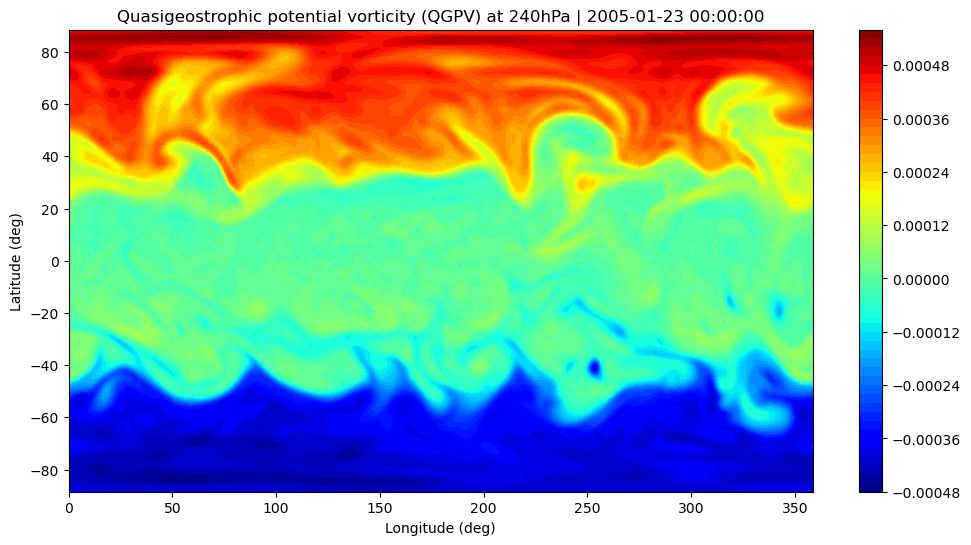

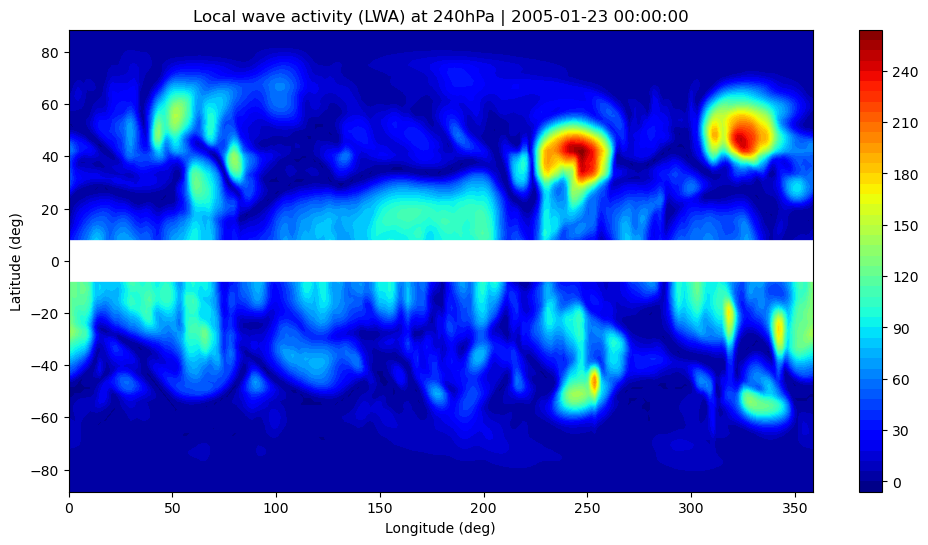

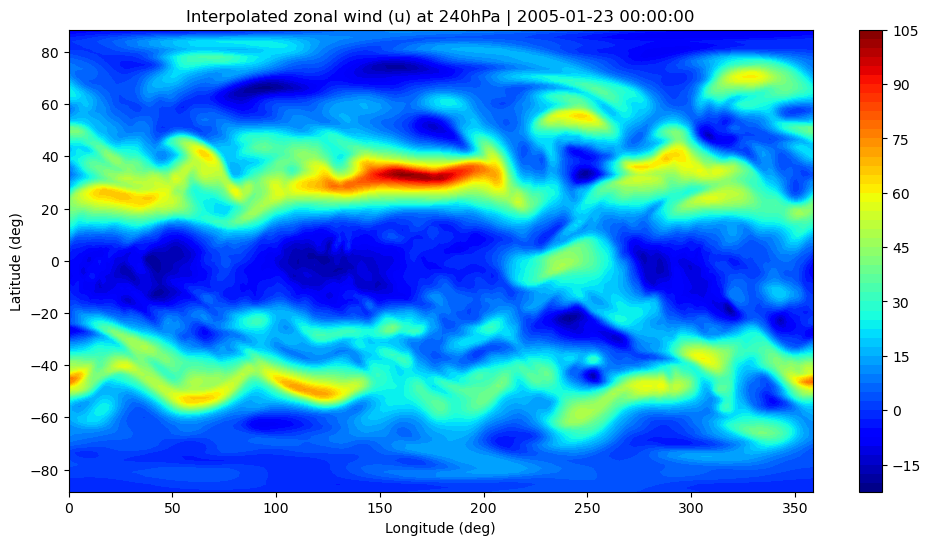

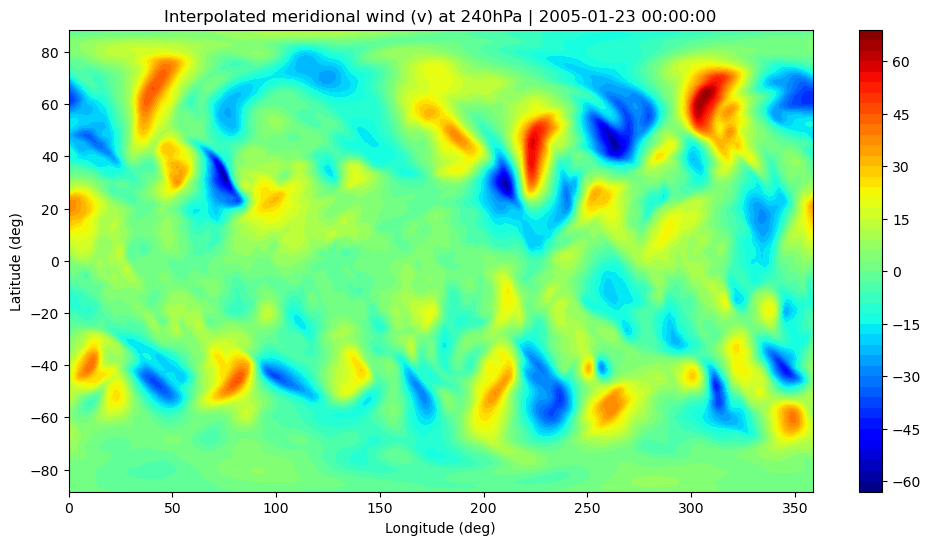

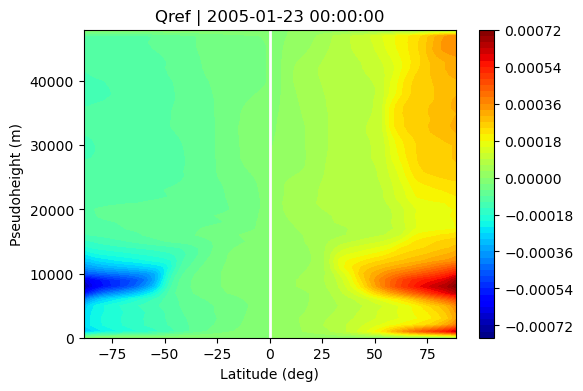

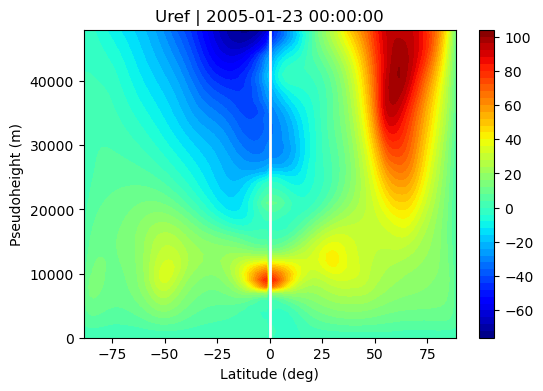

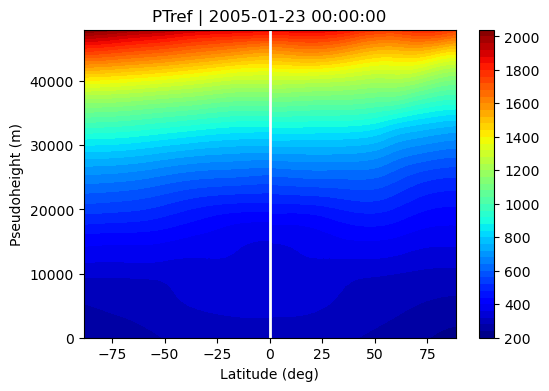

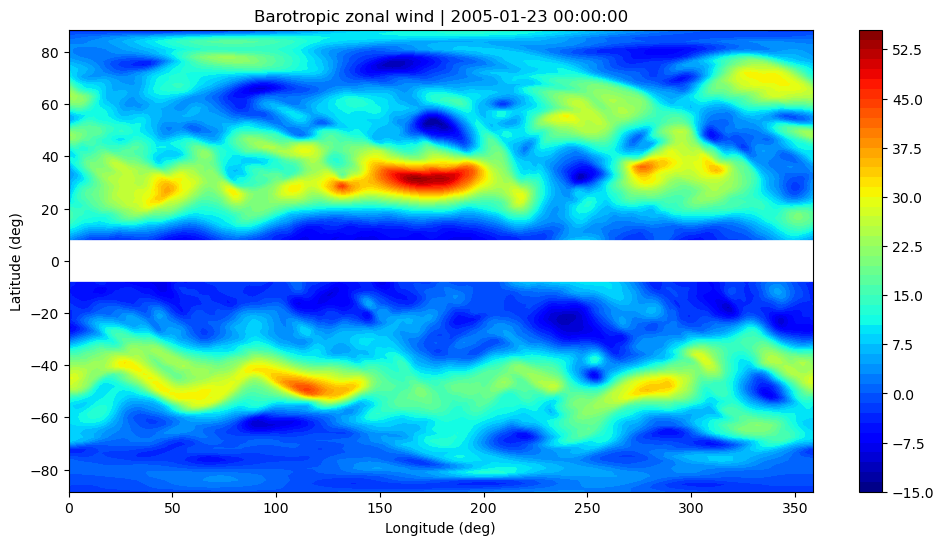

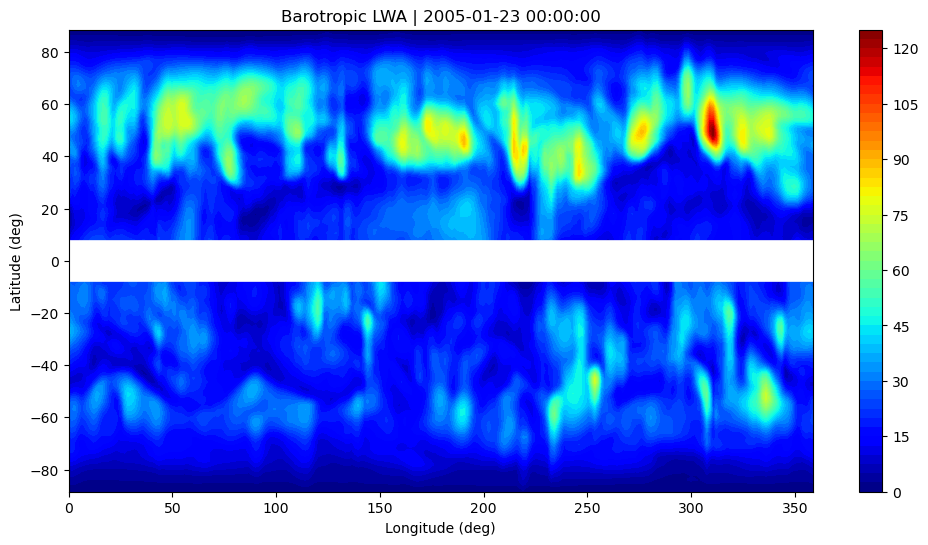

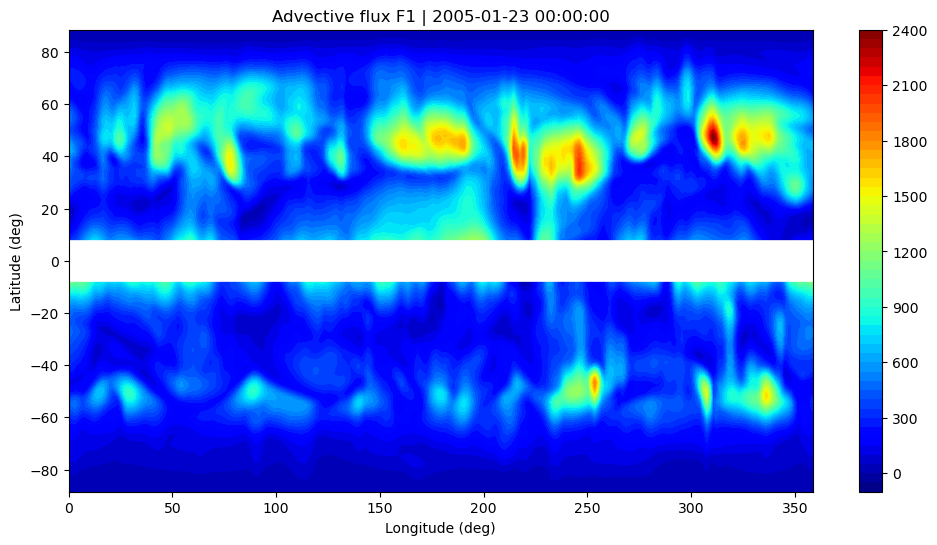

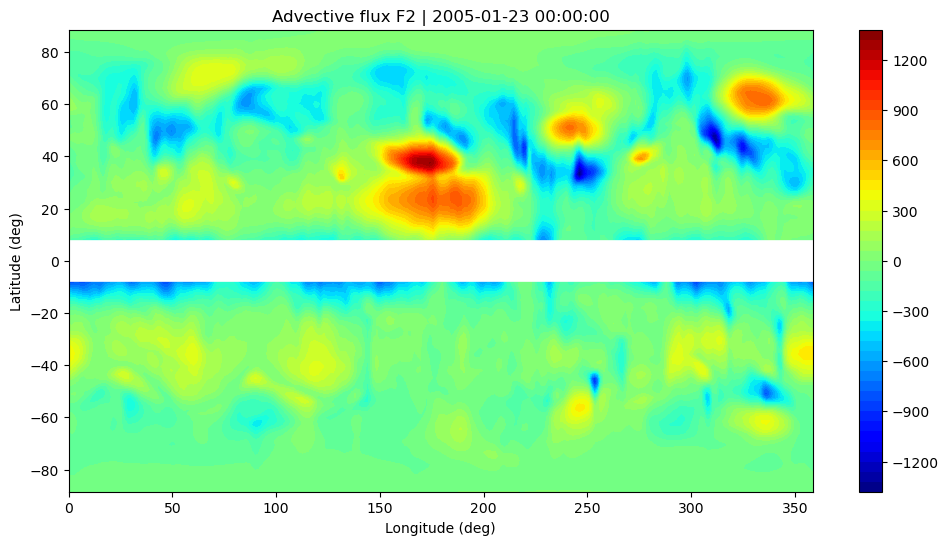

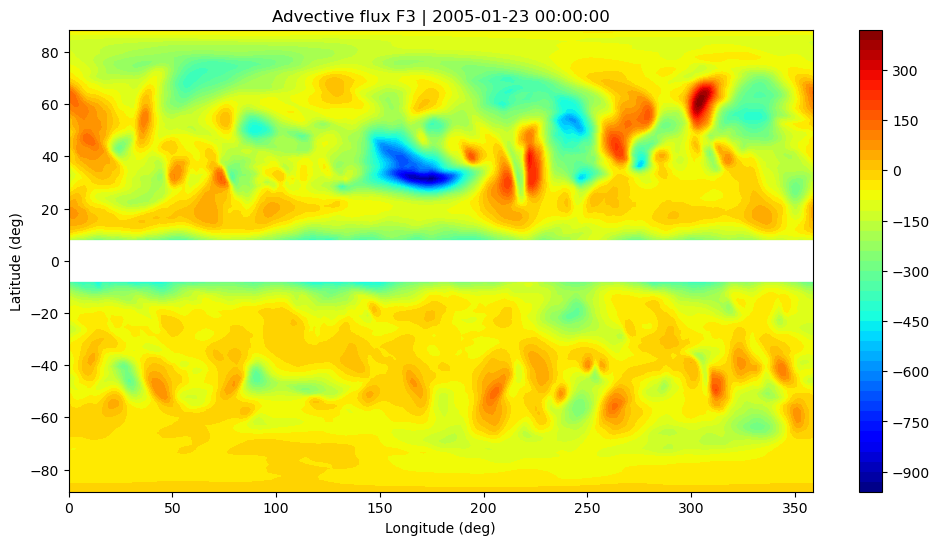

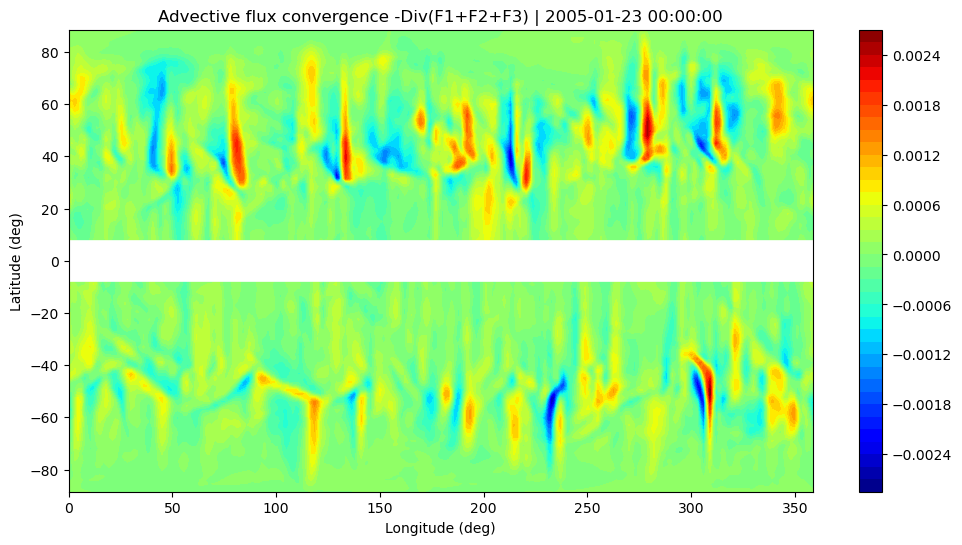

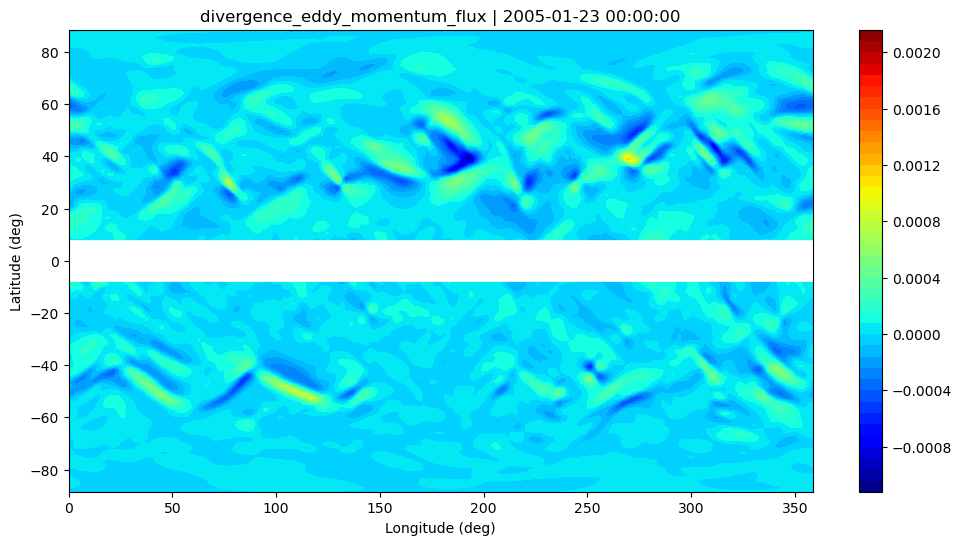

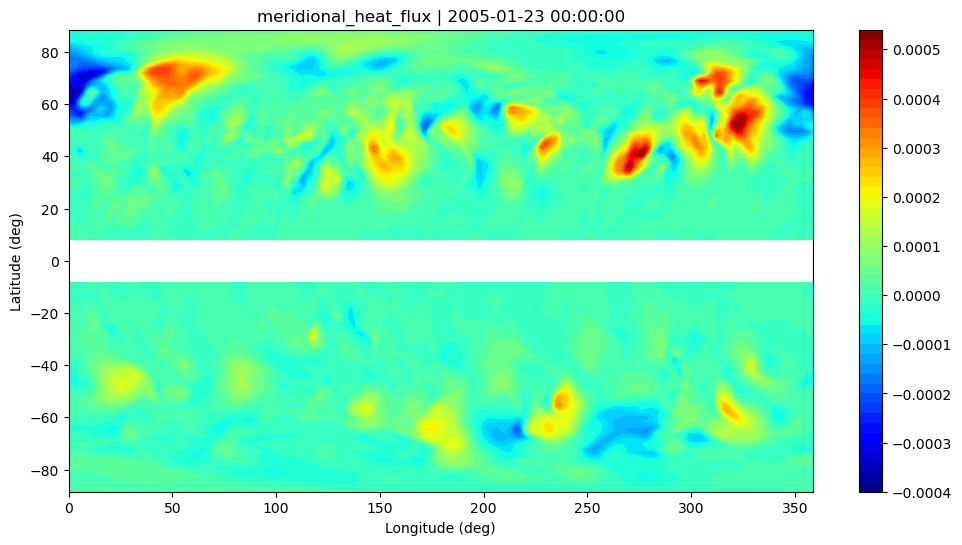

tstep = 0/32


            self.plev = [1000.          866.87789975  751.47729308  651.43905753  564.71812201
  489.54165956  424.37284568  367.87944117  318.90655732  276.45304663
  239.65103644  207.74818714  180.09231215  156.11804532  135.33528324
  117.31916609  101.7013923    88.16268936   76.42628699   66.25225915
   57.43261927   49.78706837   43.15930926   37.41385137   32.43324089
   28.11565975   24.37284407   21.12827988   18.31563889   15.87742257
   13.76378673   11.93152254   10.3431732     8.96626826    7.7726598
    6.737947      5.84097734    5.06341417    4.38936184    3.80504078
    3.29850576    2.85940174    2.47875218    2.14877548    1.86272598
    1.61475598    1.39979627    1.21345245    1.05191511]
            self.kmax = 49
            self._plev_to_height = [   -0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000.
 10000. 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000.
 20000. 21000. 22000. 23000. 24000. 25000. 26000. 27000. 2800

In [14]:
for tstep in range(32):  # or ntimes    
    
    uu = interp_to_regular_zgrid(u_file.u.isel(time=tstep).values[::-1, ::-1, :])
    vv = interp_to_regular_zgrid(v_file.v.isel(time=tstep).values[::-1, ::-1, :])
    tt = interp_to_regular_zgrid(t_file.t.isel(time=tstep).values[::-1, ::-1, :])

    qgfield_object = QGFieldNH18(xlon, ylat, new_plev, uu, vv, tt, northern_hemisphere_results_only=False, 
                                 data_on_evenly_spaced_pseudoheight_grid=True)

    qgfield_object.interpolate_fields(return_named_tuple=False)
    
    qgfield_object.compute_reference_states(return_named_tuple=False)

    qgfield_object.compute_lwa_and_barotropic_fluxes(return_named_tuple=False)

    if tstep == tstep_selected:
        # === Below demonstrate another way to access the computed variables ===
        # 3D Variables that I would choose one pressure level to display
        variables_3d = [
            (qgfield_object.qgpv, 'Quasigeostrophic potential vorticity (QGPV)'),
            (qgfield_object.lwa, 'Local wave activity (LWA)'),
            (qgfield_object.interpolated_u, 'Interpolated zonal wind (u)'),
            (qgfield_object.interpolated_v, 'Interpolated meridional wind (v)')]

        # Reference states to be displayed on y-z plane
        variables_yz = [
            (qgfield_object.qref, 'Qref'),
            (qgfield_object.uref, 'Uref'),
            (qgfield_object.ptref, 'PTref')]

        # Vertically averaged variables to be displayed on x-y plane
        variables_xy = [
            (qgfield_object.u_baro, 'Barotropic zonal wind'),
            (qgfield_object.lwa_baro, 'Barotropic LWA'),
            (qgfield_object.adv_flux_f1, 'Advective flux F1'),
            (qgfield_object.adv_flux_f2, 'Advective flux F2'),
            (qgfield_object.adv_flux_f3, 'Advective flux F3'),
            (qgfield_object.convergence_zonal_advective_flux, 'Advective flux convergence -Div(F1+F2+F3)'),
            (qgfield_object.divergence_eddy_momentum_flux, 'divergence_eddy_momentum_flux'),
            (qgfield_object.meridional_heat_flux, 'meridional_heat_flux')
        ]
        
        # Plot 240 hPa of 3D-variables
        for variable, name in variables_3d:
            plt.figure(figsize=(12,6))
            plt.contourf(xlon, ylat[1:-1], variable[plev_selected, 1:-1, :], 50, cmap='jet')
            if name=='Local wave activity (LWA)':
                plt.axhline(y=0, c='w', lw=30)
            plt.colorbar()
            plt.ylabel('Latitude (deg)')
            plt.xlabel('Longitude (deg)')
            plt.title(name + ' at 240hPa | ' + str(tstamp[tstep]))
            plt.show()
        
        # Plot reference states
        for variable, name in variables_yz:
            plt.figure(figsize=(6,4))
            plt.contourf(ylat[1:-1], height, variable[:, 1:-1], 50, cmap='jet')
            plt.axvline(x=0, c='w', lw=2)
            plt.xlabel('Latitude (deg)')
            plt.ylabel('Pseudoheight (m)')
            plt.colorbar()
            plt.title(name + ' | ' + str(tstamp[tstep]))
            plt.show()

        # Plot barotropic (2D-)variables
        for variable, name in variables_xy:
            plt.figure(figsize=(12,6))
            plt.contourf(xlon, ylat[1:-1], variable[1:-1, :], 50, cmap='jet')
            plt.axhline(y=0, c='w', lw=30)
            plt.ylabel('Latitude (deg)')
            plt.xlabel('Longitude (deg)')
            plt.colorbar()
            plt.title(name + ' | ' + str(tstamp[tstep]))
            plt.show()

    print('tstep = {}/{}\n'.format(tstep, ntimes))
